<a href="https://colab.research.google.com/github/hs0224/a-professor-student-research-club/blob/MinWooooooo/MinwooWorkspace/imageclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [2]:
import numpy as np
from fastcore.xtras import Path # @patch'd properties to the Pathlib module

from fastai.callback.fp16 import to_fp16
from fastai.callback.schedule import fit_one_cycle, lr_find 

from fastai.data.block import CategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, RegexLabeller

from fastai.interpret import ClassificationInterpretation
from fastai.learner import Learner # imports @patch'd properties to Learner including `save`, `load`, `freeze`, and `unfreeze`

from fastai.metrics import error_rate

from fastai.vision.augment import aug_transforms, RandomResizedCrop
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageDataLoaders, ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models.resnet import resnet34, resnet50

In [3]:
help(untar_data)

Help on function untar_data in module fastai.data.external:

untar_data(url: 'str', archive: 'Path' = None, data: 'Path' = None, c_key: 'str' = 'data', force_download: 'bool' = False, base: 'str' = '~/.fastai') -> 'Path'
    Download `url` using `FastDownload.get`



fastai자체 PETS 이미지 dataset

In [4]:
path = untar_data(URLs.PETS)


시드??

In [5]:
np.random.seed(2)

In [6]:
path.ls()[:3]

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

DataLoaders 설계


In [7]:
#path에 저장된 데이터의 파일 이름 and 패턴
path = untar_data(URLs.PETS)
fnames = get_image_files(path/'images')
pat = r'(.+)_\d+.jpg$'

In [8]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz'

In [9]:
fnames = get_image_files(path/'images')
fnames

(#7390) [Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_104.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_35.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_199.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_182.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_23.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_7.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_100.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_112.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Persian_26.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_76.jpg')...]

이미지를 동일한 크기로, 수행할 일부 확대 및 정규화

In [10]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=64

최상위 수준 API

In [11]:
dls = ImageDataLoaders.from_name_re(path, fnames, pat, batch_tfms=batch_tfms, 
                                   item_tfms=item_tfms, bs=bs)

DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files(경로의 모든 이미지),
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [12]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [13]:
path_im = path/'images'

In [14]:
dls = pets.dataloaders(path_im, bs=bs)

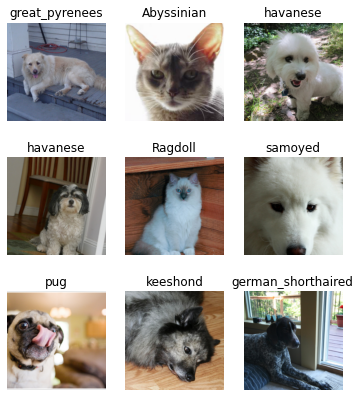

In [15]:
dls.show_batch(max_n=9, figsize=(6,7))

In [16]:
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [17]:
dls.vocab.o2i

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [18]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=error_rate).to_fp16()

/usr/local/lib/python3.8/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [29]:
learn.export()

In [19]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.863255,0.365309,0.112991,01:10
1,0.668983,0.258504,0.082544,01:04
2,0.382142,0.240932,0.078484,01:09
3,0.285103,0.233967,0.072395,01:12


In [20]:
learn.save('stage_1')

Path('models/stage_1.pth')

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

True

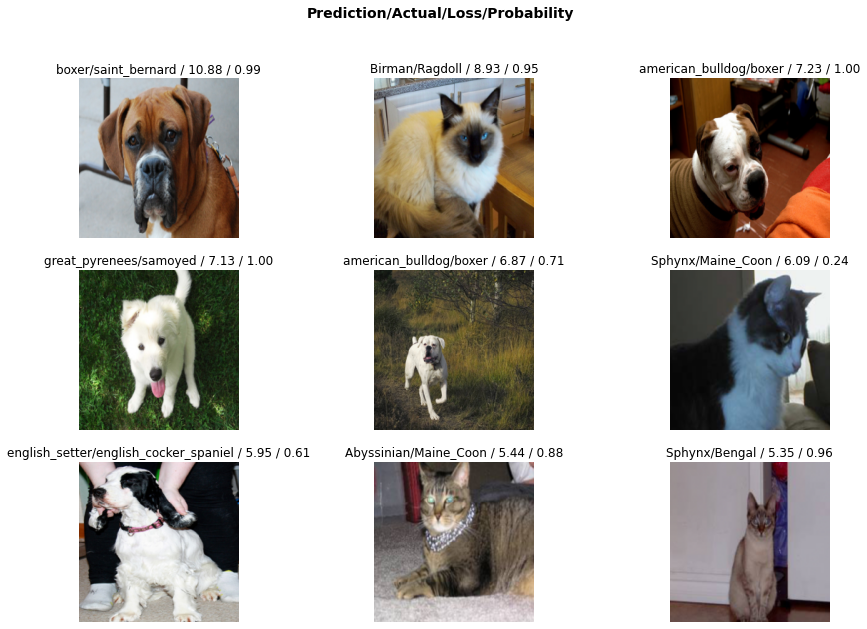

In [22]:
interp.plot_top_losses(9, figsize=(15,10))

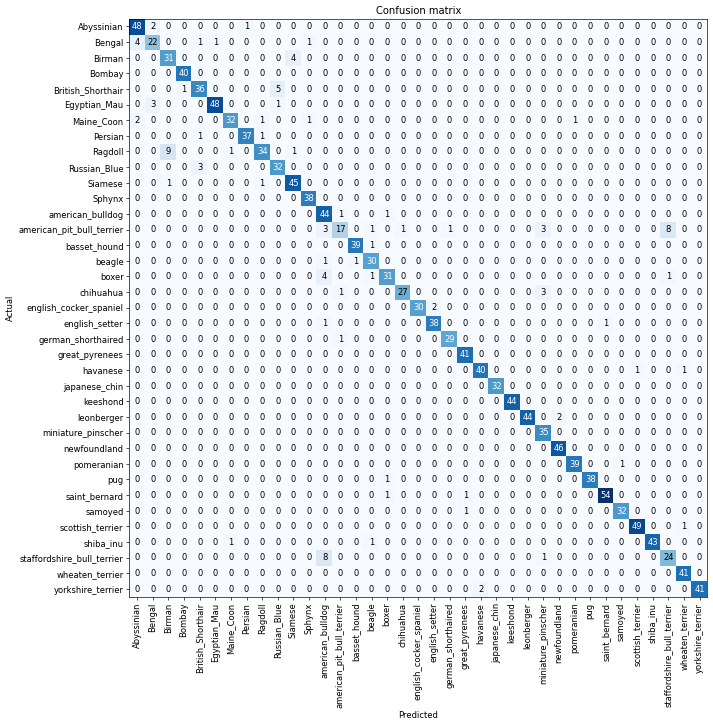

In [23]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [24]:
interp.most_confused(min_val=3)

[('Ragdoll', 'Birman', 9),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 8),
 ('staffordshire_bull_terrier', 'american_bulldog', 8),
 ('British_Shorthair', 'Russian_Blue', 5),
 ('Bengal', 'Abyssinian', 4),
 ('Birman', 'Siamese', 4),
 ('boxer', 'american_bulldog', 4),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('american_pit_bull_terrier', 'miniature_pinscher', 3),
 ('chihuahua', 'miniature_pinscher', 3)]

In [25]:
learn.load('stage_1');
learn.unfreeze()
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.148289,3.543533,0.618403,01:08
1,1.055677,1.087727,0.302436,01:14
2,0.627087,0.506555,0.166441,01:12
3,0.319047,0.380134,0.117050,01:07


SuggestedLRs(valley=1.9054607491852948e-06)

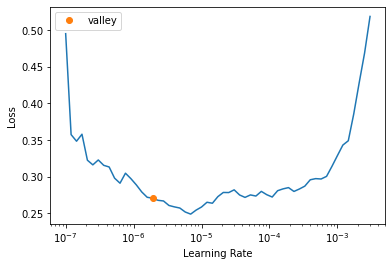

In [26]:
learn.load('stage_1');
learn.lr_find()

In [27]:
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.251900,0.223288,0.068336,01:07
1,0.229252,0.214154,0.068336,01:05
2,0.207173,0.211486,0.062923,01:06
3,0.189514,0.206860,0.063599,01:07


In [28]:
learn.save('stage_2')

Path('models/stage_2.pth')

In [31]:
learn_inf = load_learner('/content/export.pkl')

In [81]:
pred,pred_idx,probs=learn_inf.predict('/content/dog-gebef23663_1280.jpg')
probs

TensorBase([2.9256e-07, 2.5683e-08, 9.5339e-08, 4.2671e-08, 7.5336e-08,
            1.1045e-08, 8.9672e-08, 3.2978e-07, 4.9193e-07, 9.9054e-09,
            1.8756e-07, 4.6753e-09, 4.8759e-07, 2.1134e-08, 2.6926e-09,
            6.2594e-08, 6.8242e-09, 3.6731e-06, 8.5748e-08, 5.9869e-08,
            2.3665e-08, 9.5141e-07, 4.9238e-07, 5.8931e-06, 7.1559e-07,
            2.3474e-07, 3.9234e-08, 4.8479e-07, 9.9992e-01, 9.8627e-08,
            5.0303e-08, 4.7411e-05, 2.1463e-08, 1.3562e-05, 3.5534e-09,
            1.2899e-07, 1.8376e-07])

In [43]:
learn_inf.dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [82]:
for i in range(len(learn_inf.dls.vocab)):
  print(learn_inf.dls.vocab[i], f'{probs[i]:.04f}')

Abyssinian 0.0000
Bengal 0.0000
Birman 0.0000
Bombay 0.0000
British_Shorthair 0.0000
Egyptian_Mau 0.0000
Maine_Coon 0.0000
Persian 0.0000
Ragdoll 0.0000
Russian_Blue 0.0000
Siamese 0.0000
Sphynx 0.0000
american_bulldog 0.0000
american_pit_bull_terrier 0.0000
basset_hound 0.0000
beagle 0.0000
boxer 0.0000
chihuahua 0.0000
english_cocker_spaniel 0.0000
english_setter 0.0000
german_shorthaired 0.0000
great_pyrenees 0.0000
havanese 0.0000
japanese_chin 0.0000
keeshond 0.0000
leonberger 0.0000
miniature_pinscher 0.0000
newfoundland 0.0000
pomeranian 0.9999
pug 0.0000
saint_bernard 0.0000
samoyed 0.0000
scottish_terrier 0.0000
shiba_inu 0.0000
staffordshire_bull_terrier 0.0000
wheaten_terrier 0.0000
yorkshire_terrier 0.0000


In [62]:
learn_inf.dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [70]:
probs[0]

TensorBase(2.9256e-07)